In [28]:
from fuzzywuzzy import process
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
current_file_path = Path.cwd()
root = current_file_path.parent

external_path = root / 'data' / 'external_data' 
processed_path = root / 'data'/ 'processed_data'

In [30]:
rtrs_data = pd.read_csv(processed_path / 'brazil_rtrs.csv', encoding = 'iso-8859-14', decimal=',')
farm_branches = pd.read_csv(processed_path / 'farm_branches.csv', usecols = ['State', 'City', 'Organization'])
trase = pd.read_excel(external_path / 'trase_soy_2-6-0.xlsx')

In [31]:
def find_similarities(list1, list2, limit=75):
    """
    Finds similar strings between two lists using FuzzyWuzzy.
    
    Parameters:
    - list1: List of strings to compare with the second list.
    - list2: List of strings against which the first list will be compared.
    - threshold: Similarity threshold for considering a string as a match (default 75).
    
    Returns:
    - A list of tuples containing the string from list1, the most similar string from list2 and the similarity score.
    """
    
    similar_results = []

    for item in list1:
        # Find the best match for 'item' in 'list2'
        best_match, score = process.extractOne(item, list2)
        
        # Check if the similarity is above the defined threshold
        if score >= limit:
            similar_results.append(best_match)
            
    return similar_results

In [32]:
#Similarity between Trase and RTRS
amazon_states = [
    "ACRE",
    "AMAPA",
    "AMAZONAS",
    "MARANHAO",
    "MATO GROSSO",
    "PARA",
    "RONDONIA",
    "RORAIMA",
    "TOCANTINS"
]

#trase_amazon = trase[trase['STATE'].isin(amazon_states)]
rtrs_groups = find_similarities(rtrs_data['Organization'].unique().tolist(), trase['EXPORTER GROUP'].unique().tolist(), limit=93)
rtrs_groups.append('ADM')
rtrs_groups.append('SLC')
trase['IS_RTRS'] = trase['EXPORTER GROUP'].apply(lambda x: 1 if x in rtrs_groups else 0)

In [33]:
trase.shape

(311434, 24)

In [34]:
trase[['EXPORTER GROUP', 'IS_RTRS']]

,EXPORTER GROUP,IS_RTRS
0,DOMESTIC CONSUMPTION,0
1,DOMESTIC CONSUMPTION,0
2,DOMESTIC CONSUMPTION,0
3,CARGILL,0
4,CARGILL,0
...,...,...
311429,SODRUGESTVO AGRONEGOCIOS SA,0
311430,SODRUGESTVO DO BRASIL REPRESENTACAO IMPORTACAO...,0
311431,USINA MANDU,0
311432,VOTORANTIM COMERCIAL EXPORTADORA E IMPORTADORA,0


In [35]:
trase.columns

Index(['YEAR', 'COUNTRY OF PRODUCTION', 'BIOME', 'STATE',
       'MUNICIPALITY OF PRODUCTION', 'LOGISTICS HUB', 'PORT OF EXPORT',
       'EXPORTER', 'EXPORTER GROUP', 'IMPORTER', 'IMPORTER GROUP',
       'COUNTRY OF FIRST IMPORT', 'ECONOMIC BLOC', 'TYPE',
       'Soy deforestation exposure', 'FOB_USD',
       'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
       'SOY_EQUIVALENT_TONNES', 'LAND_USE_HA',
       'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
       'Soy deforestation risk', 'ZERO_DEFORESTATION_BRAZIL_SOY',
       'TRASE_GEOCODE', 'IS_RTRS'],
      dtype='object')

In [36]:
trase = trase[['EXPORTER GROUP','Soy deforestation exposure', 'FOB_USD', 'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
               'SOY_EQUIVALENT_TONNES', 'LAND_USE_HA', 'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
               'Soy deforestation risk', 'IS_RTRS', 'STATE','MUNICIPALITY OF PRODUCTION', 'YEAR']]

In [37]:
trase.rename(columns={'EXPORTER GROUP': 'Group', 
                      'Soy deforestation exposure': 'SoyDefExp',
                      'FOB_USD': 'ExpFOB',
                      'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE': 'CO2Gross',
                      'SOY_EQUIVALENT_TONNES': 'SoyTonnes',
                      'LAND_USE_HA': 'LandUse',
                      'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE': 'CO2Net',
                      'Soy deforestation risk': 'SoyRisk',
                      'IS_RTRS': 'IsRTRS' ,
                      'STATE': 'State',
                      'MUNICIPALITY OF PRODUCTION': 'City',
                      'YEAR': 'Year'
                      }, inplace=True)

In [38]:
trase['Yield'] = trase['SoyTonnes'] / trase['LandUse']

In [39]:
trase.head()

,Group,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,State,City,Year,Yield
0,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,81.000000,27.000000,0.0,0.0,0,ACRE,CAPIXABA,2017,3.000
1,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1279.882771,496.078593,0.0,0.0,0,ACRE,CAPIXABA,2019,2.580
2,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1500.000000,480.000000,0.0,0.0,0,ACRE,CAPIXABA,2020,3.125
3,CARGILL,0.0,31812.773141,0.0,83.358068,26.049396,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200
4,CARGILL,0.0,23971.251881,0.0,59.739949,18.668734,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200


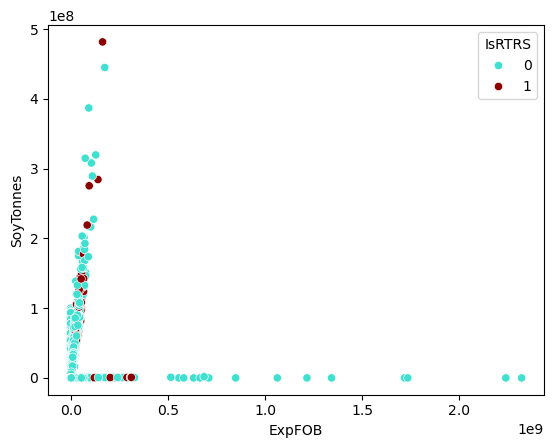

In [40]:
palette = {0: 'turquoise', 1: '#8B0000'}

sns.scatterplot(data=trase, x='ExpFOB', y='SoyTonnes', hue='IsRTRS', palette=palette)

plt.show()

In [41]:
trase[trase['IsRTRS'] == 1].describe()

,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,Year,Yield
count,42434.000000,7.790600e+04,4.243100e+04,7.790600e+04,7.377100e+04,4.243400e+04,42434.000000,77906.0,77906.000000,73771.000000
mean,35.900147,1.774800e+06,5.410746e+03,4.287280e+05,7.441183e+03,4.748644e+03,15.835769,1.0,2013.413190,88.971722
std,239.876390,6.366477e+06,3.236172e+04,4.905221e+06,3.397033e+05,2.837039e+04,111.741663,0.0,5.425817,508.164572
min,0.000000,1.700184e-10,0.000000e+00,4.860248e-13,5.902755e+00,0.000000e+00,0.000000,1.0,2004.000000,0.002000
25%,0.013259,5.615469e+04,3.386653e+00,1.545641e+02,5.848655e+01,3.093106e+00,0.006405,1.0,2008.000000,2.550000
50%,0.353748,2.312248e+05,7.832313e+01,6.398339e+02,2.411612e+02,7.056698e+01,0.163431,1.0,2014.000000,3.000000
75%,4.440915,1.016539e+06,8.636250e+02,2.893867e+03,9.997530e+02,7.674043e+02,1.995764,1.0,2019.000000,3.360000
max,8729.993955,3.119914e+08,1.315313e+06,4.815032e+08,6.226262e+07,1.155714e+06,6686.939456,1.0,2020.000000,3986.929716


In [42]:
trase[trase['IsRTRS'] == 0].describe()

,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,Year,Yield
count,139620.000000,2.335280e+05,1.396040e+05,2.335280e+05,2.100330e+05,1.396200e+05,139620.000000,233528.0,233528.000000,210033.000000
mean,26.104182,1.157381e+06,3.915315e+03,2.710223e+05,5.496631e+03,3.435406e+03,11.535527,0.0,2014.527915,50.193438
std,258.334712,1.150395e+07,3.697212e+04,4.052906e+06,3.527166e+05,3.256968e+04,126.070213,0.0,5.180321,380.458653
min,0.000000,0.000000e+00,0.000000e+00,2.153751e-26,2.550059e+00,0.000000e+00,0.000000,0.0,2004.000000,0.000720
25%,0.000000,2.715121e+04,0.000000e+00,9.813764e+01,3.639268e+01,0.000000e+00,0.000000,0.0,2010.000000,2.686600
50%,0.075577,1.086262e+05,1.756208e+01,3.875729e+02,1.381925e+02,1.586185e+01,0.036685,0.0,2016.000000,3.060000
75%,1.357141,5.191059e+05,2.760527e+02,1.966869e+03,6.523302e+02,2.475639e+02,0.646265,0.0,2019.000000,3.450000
max,24633.228956,2.319586e+09,3.323160e+06,4.448552e+08,9.350598e+07,2.871140e+06,20507.502735,0.0,2020.000000,6415.295909


In [43]:
amazon_states = [
    "ACRE",
    "AMAPA",
    "AMAZONAS",
    "MARANHAO",
    "MATO GROSSO",
    "PARA",
    "RONDONIA",
    "RORAIMA",
    "TOCANTINS"
]

trase_amazon = trase[trase['State'].isin(amazon_states)]

In [44]:
trase_consolidated_br = trase.groupby(['Group', 'IsRTRS']).agg({'SoyDefExp': 'mean', 
                                        'ExpFOB': 'mean',
                                        'CO2Gross': 'mean',
                                        'CO2Net': 'mean',
                                        'SoyTonnes': 'mean', 
                                        'LandUse':'mean',
                                        'SoyRisk': 'mean',
                                        'Yield': 'mean',
                                        }).reset_index()

In [45]:
trase_consolidated_amazon = trase_amazon.groupby(['Group', 'IsRTRS']).agg({'SoyDefExp': 'mean', 
                                        'ExpFOB': 'mean',
                                        'CO2Gross': 'mean',
                                        'CO2Net': 'mean',
                                        'SoyTonnes': 'mean', 
                                        'LandUse':'mean',
                                        'SoyRisk': 'mean',
                                        'Yield': 'mean',
                                        }).reset_index()

# case brasil

In [76]:
total_exports_by_year_br = trase.groupby('Year')['SoyTonnes'].sum()

In [47]:
trase = trase.merge(total_exports_by_year_br.rename('TotalExports'), on='Year')

In [77]:
# Calcular a produção total por status de certificação e ano
certified_production_by_year = trase[trase['IsRTRS'] == 1].groupby('Year')['SoyTonnes'].sum()
non_certified_production_by_year = trase[trase['IsRTRS'] == 0].groupby('Year')['SoyTonnes'].sum()

In [78]:
growth_rate_market = total_exports_by_year_br.pct_change().dropna()

In [79]:
growth_rate_market.tolist()

[0.19293237067883373,
 -0.4590204472245941,
 0.7442266445672592,
 0.37035999217170024,
 -0.04958340297996722,
 -0.02037101299246602,
 0.3403737178063331,
 -0.012403220853233643,
 0.09175006303411148,
 0.07352489006016816,
 -0.07121766662514195,
 0.061917536635382575,
 0.12554491956222513,
 -0.0369965390001028,
 -0.7471629090588002,
 0.9118865607785933]

In [80]:
anos = growth_rate_market.index.tolist()
crescimento = growth_rate_market.tolist()

In [81]:
growth_rate_market

Year
2005    0.192932
2006   -0.459020
2007    0.744227
2008    0.370360
2009   -0.049583
2010   -0.020371
2011    0.340374
2012   -0.012403
2013    0.091750
2014    0.073525
2015   -0.071218
2016    0.061918
2017    0.125545
2018   -0.036997
2019   -0.747163
2020    0.911887
Name: SoyTonnes, dtype: float64

In [82]:
# Inicializar listas para armazenar os resultados
market_expansion_effect = []
competitiveness_effect = []

# Calcular o efeito de expansão do mercado e o efeito de competitividade
for year in growth_rate_market.index[1:]:
    # Efeito de expansão do mercado para certificado e não certificado
    me_certified = growth_rate_market[year] * certified_production_by_year[year - 1]
    me_non_certified = growth_rate_market[year] * non_certified_production_by_year[year - 1]

    # Efeito de competitividade
    ce_certified = certified_production_by_year[year] - me_certified
    ce_non_certified = non_certified_production_by_year[year] - me_non_certified

    # Armazenar os resultados
    market_expansion_effect.append({'Year': year, 'Certified': me_certified, 'Non_certified': me_non_certified})
    competitiveness_effect.append({'Year': year, 'Certified': ce_certified, 'Non_certified': ce_non_certified})

df_market_expansion = pd.DataFrame(market_expansion_effect)
df_competitiveness = pd.DataFrame(competitiveness_effect)

# Exibir os resultados
print("Market Expansion Effect:")
print(df_market_expansion)
print("\nCompetitiveness Effect:")
print(df_competitiveness)

Market Expansion Effect:
    Year     Certified  Non_certified
0   2006 -2.194578e+08  -1.711837e+09
1   2007  2.755880e+08   1.418370e+09
2   2008  4.194367e+08   1.050926e+09
3   2009 -1.106994e+08  -1.590567e+08
4   2010 -5.005345e+07  -5.527886e+07
5   2011  7.404799e+08   9.836367e+08
6   2012 -4.544380e+07  -3.876762e+07
7   2013  2.494364e+08   3.657725e+08
8   2014  2.102019e+08   3.280354e+08
9   2015 -2.066332e+08  -3.530462e+08
10  2016  1.795967e+08   2.723416e+08
11  2017  3.723876e+08   6.007078e+08
12  2018 -1.018394e+08  -2.209209e+08
13  2019 -1.463712e+09  -4.813434e+09
14  2020  3.019278e+08   1.635068e+09

Competitiveness Effect:
    Year     Certified  Non_certified
0   2006  5.897590e+08   3.617668e+09
1   2007  8.569229e+08   1.419209e+09
2   2008  1.813154e+09   2.156936e+09
3   2009  2.567791e+09   2.872661e+09
4   2010  2.225544e+09   2.945152e+09
5   2011  2.923391e+09   2.141973e+09
6   2012  2.764095e+09   4.025386e+09
7   2013  2.609485e+09   4.095783e+09


In [83]:
yield_trase = trase.groupby('Year').agg({'Yield': 'sum'}).reset_index()
df_market_expansion['Yield'] = yield_trase['Yield'].copy(deep=True)
df_competitiveness['Yield'] = yield_trase['Yield'].copy(deep=True)

In [84]:
df_market_expansion['Year'] = df_market_expansion['Year'].apply(lambda x: 0 if x < 2012 else 1)
df_competitiveness['Year'] = df_competitiveness['Year'].apply(lambda x: 0 if x < 2012 else 1)

In [85]:
df_market_expansion = df_market_expansion.groupby('Year').agg({'Certified': 'sum', 'Non_certified': 'sum', 'Yield': 'sum'}).reset_index()
df_competitiveness = df_competitiveness.groupby('Year').agg({'Certified': 'sum', 'Non_certified': 'sum', 'Yield': 'sum'}).reset_index()

In [87]:
df_market_expansion

,Year,Certified,Non_certified,Yield
0,0,1.055294e+09,1.526760e+09,3.051819e+06
1,1,-5.040781e+08,-2.224244e+09,1.310460e+07


In [86]:
df_competitiveness

,Year,Certified,Non_certified,Yield
0,0,1.097656e+10,1.515360e+10,3.051819e+06
1,1,2.120470e+10,4.176879e+10,1.310460e+07


In [88]:
def calcular_taxa_mudanca(valor_inicial, valor_final):
    """
    Calcula a taxa de mudança entre dois valores, adequado para situações onde os valores passam de positivos para negativos ou vice-versa.
    
    Parâmetros:
    valor_inicial (float): O valor no início do período.
    valor_final (float): O valor no final do período.
    
    Retorna:
    float: A taxa de mudança entre os valores especificados.
    """
    if valor_inicial == 0:
        raise ValueError("O valor inicial deve ser diferente de zero para evitar divisão por zero.")
    
    taxa_mudanca = (valor_final - valor_inicial) / abs(valor_inicial)
    return taxa_mudanca


In [89]:
taxa1 = calcular_taxa_mudanca(1.097656e+10, 2.120470e+10)
taxa2 = calcular_taxa_mudanca(1.515360e+10, 4.176879e+10)

print(taxa1, taxa2)

0.9318165253959346 1.756360864745011


In [91]:
epr = (1.310460e+07/3.051819e+06)*1.055294e+09
print(epr)

4531463285.470075


## case amazonia

# abordagem generalista

In [54]:
ts_general_br = trase.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
ts_general_amazon = trase_amazon.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()


In [55]:
ts_general_br['Year'] = ts_general_br['Year'].apply(lambda x: 0 if x < 2012 else 1)
ts_general_amazon['Year'] = ts_general_amazon['Year'].apply(lambda x: 0 if x < 2012 else 1)


In [56]:
ts_general_split_br = ts_general_br.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
ts_general_split_amazon = ts_general_amazon.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()


In [57]:
print(ts_general_split_br)

   Year     SoyTonnes
0     0  3.644660e+10
1     1  6.024517e+10


In [58]:
print(ts_general_split_amazon)

   Year     SoyTonnes
0     0  1.626892e+10
1     1  2.629355e+10


In [59]:
def calcular_taxa_crescimento(valor_inicial, valor_final, periodos):
    taxa_crescimento = (valor_final / valor_inicial) ** (1/periodos) - 1
    return taxa_crescimento

In [60]:
taxa_cresc_geral_br = calcular_taxa_crescimento(3.644660e+10, 6.024517e+10, 1)
taxa_cresc_geral_amazon = calcular_taxa_crescimento(1.626892e+10, 2.629355e+10, 1)

print(f'taxa de crescimento do setor total Brasil: {taxa_cresc_geral_br}')
print(f'taxa de crescimento do setor total Amazônia: {taxa_cresc_geral_amazon}')

taxa de crescimento do setor total Brasil: 0.6529709218418178
taxa de crescimento do setor total Amazônia: 0.6161828812238304


# ver a certificação

In [61]:
#Brasil

NotRTRSBR = trase[trase['IsRTRS'] == 0]
RTRSBR = trase[trase['IsRTRS'] == 1]

#Amazônia
NotRTRSAM = trase_amazon[trase_amazon['IsRTRS'] == 0]
RTRSAM = trase_amazon[trase_amazon['IsRTRS'] == 1]

In [62]:
#Brasil
NotRTRSBR = NotRTRSBR.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRSBR = RTRSBR.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

NotRTRSBR['Year'] = NotRTRSBR['Year'].apply(lambda x: 0 if x < 2012 else 1)
RTRSBR['Year'] = RTRSBR['Year'].apply(lambda x: 0 if x < 2012 else 1)

In [63]:
NotRTRSAM = NotRTRSAM.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRSAM = RTRSAM.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

NotRTRSAM['Year'] = NotRTRSAM['Year'].apply(lambda x: 0 if x < 2012 else 1)
RTRSAM['Year'] = RTRSAM['Year'].apply(lambda x: 0 if x < 2012 else 1)

In [64]:
NotRTRSBR = NotRTRSBR.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRSBR = RTRSBR.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

In [65]:
NotRTRSAM = NotRTRSAM.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRSAM = RTRSAM.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

# final

In [66]:
NotRTRSBR

,Year,SoyTonnes
0,0,2.374674e+10
1,1,3.954455e+10


In [67]:
RTRSBR

,Year,SoyTonnes
0,0,1.269986e+10
1,1,2.070062e+10


In [68]:
taxa_cresc_RTRS_BR = calcular_taxa_crescimento(1.269986e+10, 2.070062e+10, 1)
taxa_cresc_NOT_RTRS_BR = calcular_taxa_crescimento(2.374674e+10, 3.954455e+10, 1)

print(f'taxa de crescimento do setor total Brasil: {taxa_cresc_geral_br}')
print(f'taxa de crescimento do setor certificado Brasil: {taxa_cresc_RTRS_BR}')
print(f'taxa de crescimento do setor nao certificado Brasil: {taxa_cresc_NOT_RTRS_BR}')

taxa de crescimento do setor total Brasil: 0.6529709218418178
taxa de crescimento do setor certificado Brasil: 0.6299880471123305
taxa de crescimento do setor nao certificado Brasil: 0.6652622633675191


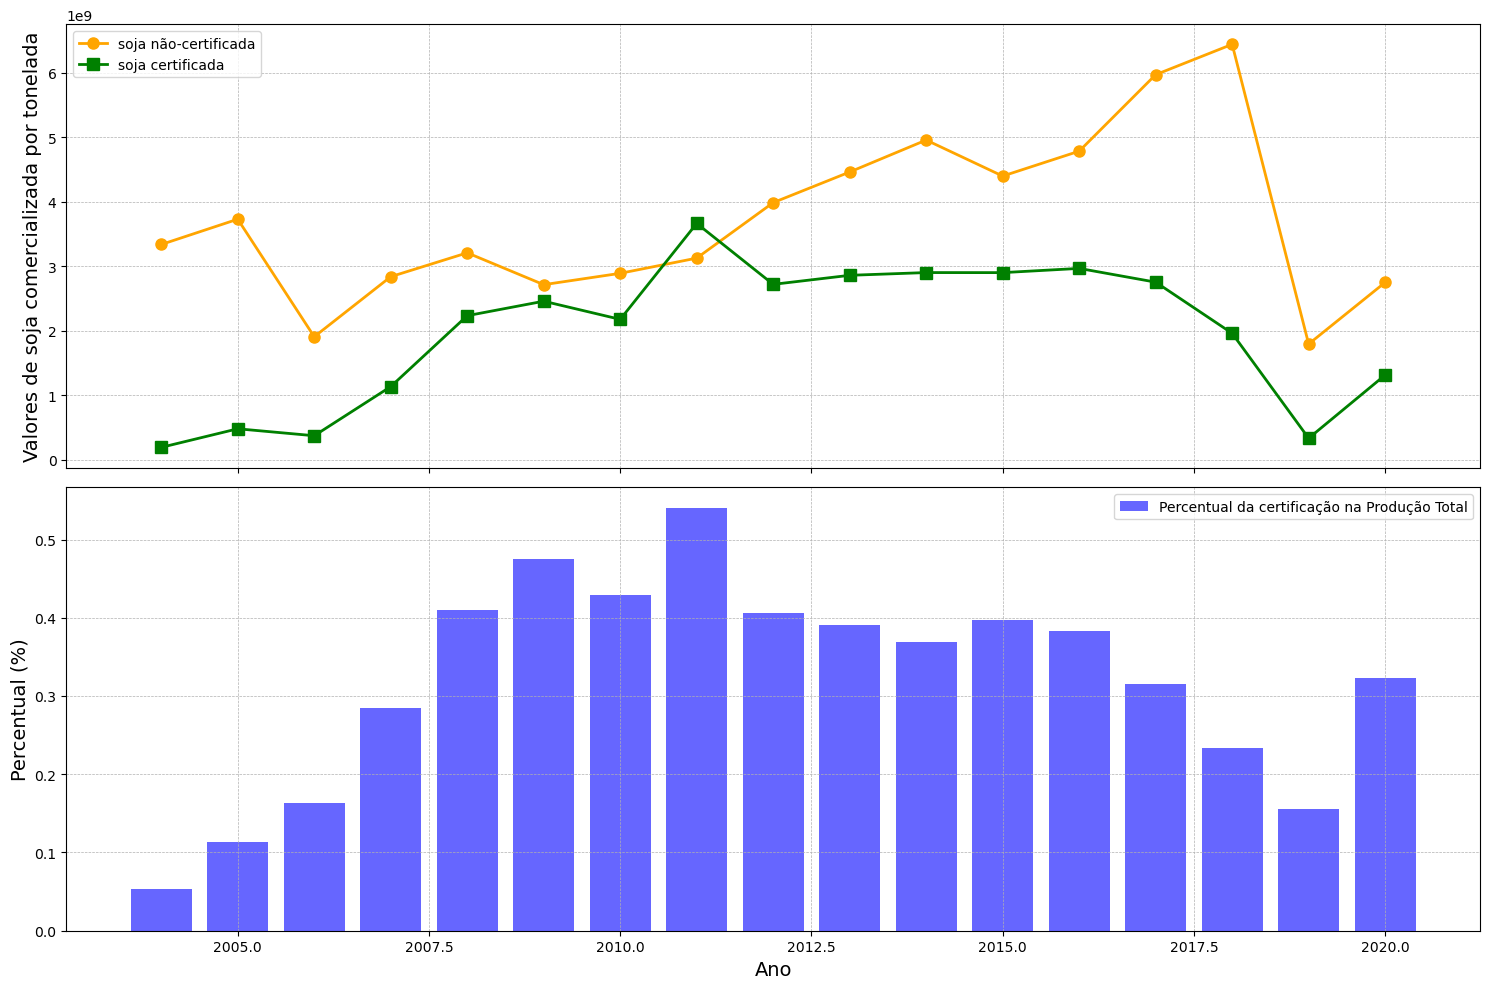

In [70]:
NotRTRS = trase[trase['IsRTRS'] == 0]
RTRS = trase[trase['IsRTRS'] == 1]

ts_notrtrs = NotRTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
ts_rtrs = RTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
ts_total = pd.merge(ts_notrtrs, ts_rtrs, on='Year', how='inner')
ts_total['Percent'] = ts_total['SoyTonnes_y'] / (ts_total['SoyTonnes_x'] + ts_total['SoyTonnes_y'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[15,10], sharex=True)  # Gráficos compartilham o mesmo eixo X

# Gráfico de linha para SoyTonnes_x e ExpFOB_y
ax1.plot(ts_total['Year'], ts_total['SoyTonnes_x'], marker='o', color='orange', label='soja não-certificada', linewidth=2, markersize=8)
ax1.plot(ts_total['Year'], ts_total['SoyTonnes_y'], marker='s', color='green', label='soja certificada', linewidth=2, markersize=8)
ax1.set_ylabel('Valores de soja comercializada por tonelada', fontsize=14)  # Define o rótulo do eixo Y para os valores de SoyTonnes
ax1.legend(loc='upper left')  # Posiciona a legenda
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adiciona grade ao gráfico

# Gráfico de barras para 'percent'
ax2.bar(ts_total['Year'], ts_total['Percent'], color='blue', alpha=0.6, label='Percentual da certificação na Produção Total')
ax2.set_xlabel('Ano', fontsize=14)  # Define o rótulo do eixo X
ax2.set_ylabel('Percentual (%)', fontsize=14)  # Define o rótulo do eixo Y para os valores percentuais
ax2.legend(loc='upper right')  # Posiciona a legenda
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adiciona grade ao gráfico

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.savefig('soja_tonelada_cadeia.png')
plt.show()  # Mostra os gráficos